### Extract Data from Hardware Model and Simulations

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

# Load the JSON data_design
filename = '1000_nodes_2000_factors_sf_100'

# Specify the path for the new folder
folder_path = Path(f"images/{filename}")
folder_path.mkdir(parents=True, exist_ok=True)

# Extract design data
with open(f"designs/{filename}.json") as f:
    data_design = json.load(f)

graph = data_design.get('inp_graph_topology', [])
designs = data_design.get('all_designs', [])

# Extract associated simulation data
with open(f"simulations/{filename}.json") as f:
    data_simulations = json.load(f)

# Initialize lists to store calculated values
all_performance_values = []
all_convergence_values = []
all_resource_percent_max = []
all_number_pes_values = []
all_node_updts_per_pe_values = []

# Initialize lists to store calculated values
PE_performances = {}

# Iterate through each design
for design in designs:
    # Calculate performance value
    performance_value = (design['design']['number_pes'] * design['design']['nodes_updt_per_pe']) / design['latency']['latency_total']
    all_performance_values.append(performance_value)

    # Calculate convergence value
    for value in data_simulations:
        if value['number_pes'] == design['design']['number_pes'] and value['nodes_updt_per_pe'] == design['design']['nodes_updt_per_pe']:
            stream_passes = value['stream_passes']
    convergence_value = design['latency']['latency_total'] * stream_passes
    all_convergence_values.append(convergence_value)

    # Get maximum resource percentage
    all_resource_percent_max.append(max(design['resources']['resources_%'].values()))

    # Get number_pes
    all_number_pes_values.append(design['design']['number_pes'])
    all_node_updts_per_pe_values.append(design['design']['nodes_updt_per_pe'])

    if design['design']['number_pes'] not in PE_performances:
        PE_performances[design['design']['number_pes']] = []

    build_dict = {}
    build_dict['performance'] = performance_value
    build_dict['convergence_value'] = convergence_value
    build_dict['resources_%'] = max(design['resources']['resources_%'].values())
    build_dict['number_pes'] = design['design']['number_pes']
    build_dict['nodes_updt_per_pe'] = design['design']['nodes_updt_per_pe']
    PE_performances[design['design']['number_pes']].append(build_dict)

FileNotFoundError: [Errno 2] No such file or directory: 'simulations/1000_nodes_2000_factors_sf_100.json'

### Find the Pareto Frontier for Each Number of PEs

In [ ]:
Parento_Frontiers = {}
for number_pes, results in PE_performances.items():
    # Collect from results
    performance_values = [x['performance'] for x in results]
    resource_percent_max = [x['resources_%'] for x in results]
    convergence_values = [x['convergence_value'] for x in results]
    
    # Identify the Pareto frontier
    pareto_indices = []
    for i in range(len(resource_percent_max)):
        is_pareto = True
        for j in range(len(resource_percent_max)):
            if resource_percent_max[j] <= resource_percent_max[i] and convergence_values[j] <= convergence_values[i] and (resource_percent_max[j] < resource_percent_max[i] or convergence_values[j] < convergence_values[i]):
                is_pareto = False
                break
        if is_pareto:
            pareto_indices.append(i)

    # Extract Pareto frontier
    pareto_resource = np.array([resource_percent_max[i] for i in pareto_indices])
    pareto_convergence = np.array([convergence_values[i] for i in pareto_indices])

    # Sort the Pareto frontier by both x-coordinate and y-coordinate
    sorted_indices = np.lexsort((pareto_convergence, pareto_resource))
    pareto_resource_sorted = pareto_resource[sorted_indices]
    pareto_convergence_sorted = pareto_convergence[sorted_indices]

    Parento_Frontiers[number_pes] = {'resources': pareto_resource_sorted, 'convergence': pareto_convergence_sorted}

### Plot Convergence against RU for each PE

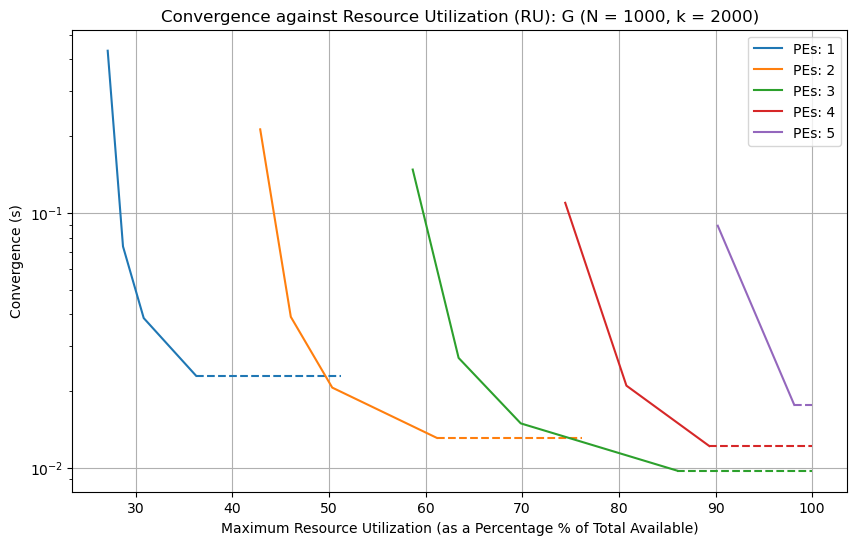

In [ ]:
# Initialize the plot
plt.figure(figsize=(10, 6))

# Iterate over each Pareto frontier
for number_pes, frontier_data in Parento_Frontiers.items():
    resources = frontier_data['resources']
    performance_values = frontier_data['convergence']
    
    # Plot the Pareto frontier and get the color used
    line, = plt.plot(resources, performance_values, label=f"PEs: {number_pes}")
    color = line.get_color()  # Get color used for this plot
    
    # Plot horizontal line at the final point with the same color
    plt.hlines(y=performance_values[-1], xmin=resources[-1], xmax=min(resources[-1]+15, 100), color=color, linestyle='--')

# Add labels and legend
plt.xlabel('Maximum Resource Utilization (as a Percentage % of Total Available)', fontsize=10)
plt.ylabel('Convergence (s)', fontsize=10)
plt.title('Convergence against Resource Utilization (RU): G (N = {}, k = {})'.format(graph['N'], graph['k']), fontsize=12)
plt.legend()

# Set y-axis to log scale if needed
plt.yscale('log')

# Show the plot
plt.grid(True)

plt.savefig(f"images/n_1000_k_2000_analysis_pe_plot_convergence.png") 
plt.show()

### Convergence vs RU Pareto

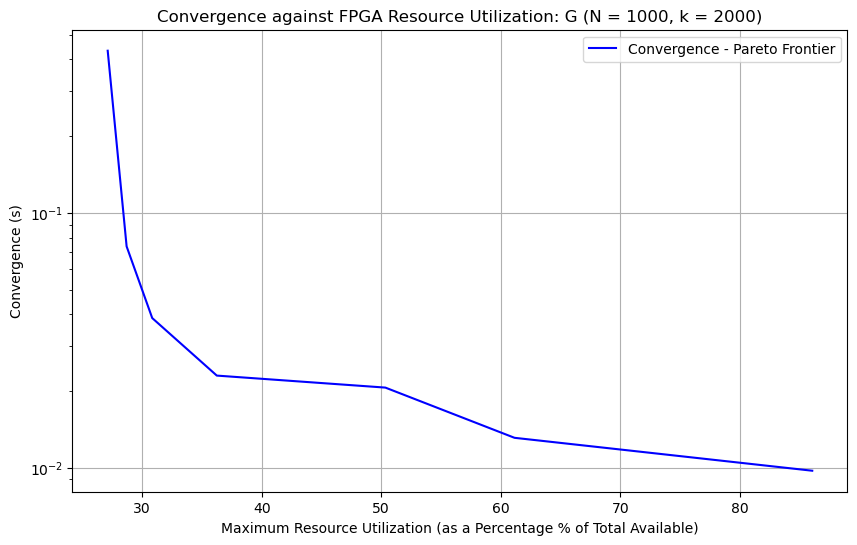

In [ ]:
# Identify the Pareto frontier
pareto_indices = []
for i in range(len(all_resource_percent_max)):
    is_pareto = True
    for j in range(len(all_resource_percent_max)):
        if all_resource_percent_max[j] <= all_resource_percent_max[i] and all_convergence_values[j] <= all_convergence_values[i] and (all_resource_percent_max[j] < all_resource_percent_max[i] or all_convergence_values[j] < all_convergence_values[i]):
            is_pareto = False
            break
    if is_pareto:
        pareto_indices.append(i)

# Extract Pareto frontier
pareto_resource = np.array([all_resource_percent_max[i] for i in pareto_indices])
pareto_convergence = np.array([all_convergence_values[i] for i in pareto_indices])

# Sort the Pareto frontier by both x-coordinate and y-coordinate
sorted_indices = np.lexsort((pareto_convergence, pareto_resource))
pareto_resource_performance_new_frontier = pareto_resource[sorted_indices]
convergence_values_pareto_new_frontier = pareto_convergence[sorted_indices]


# Plot
plt.figure(figsize=(10, 6))

# Plot the Pareto frontier line
plt.plot(pareto_resource_performance_new_frontier, convergence_values_pareto_new_frontier, color='blue', label='Convergence - Pareto Frontier')

plt.yscale('log')

# Add legend
plt.legend(fontsize=10, loc='upper right')  # Adjusted font size here

# Add labels and title
plt.xlabel('Maximum Resource Utilization (as a Percentage % of Total Available)', fontsize=10)  # Adjusted font size here
plt.ylabel('Convergence (s)', fontsize=10)  # Adjusted font size here
plt.title('Convergence against FPGA Resource Utilization: G (N = {}, k = {})'.format(graph['N'], graph['k']), fontsize=12)  # Adjusted font size here

# Show plot
plt.grid(True)
plt.show()

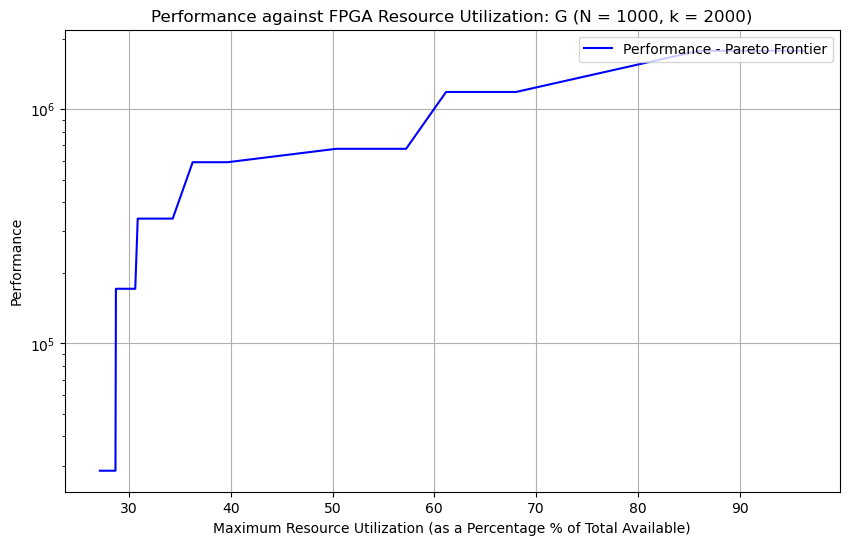

In [ ]:
# Identify the Pareto frontier
pareto_indices = []
for i in range(len(all_resource_percent_max)):
    is_pareto = True
    for j in range(len(all_resource_percent_max)):
        if all_resource_percent_max[j] <= all_resource_percent_max[i] and all_performance_values[j] >= all_performance_values[i] and (all_resource_percent_max[j] > all_resource_percent_max[i] or all_performance_values[j] > all_performance_values[i]):
            is_pareto = False
            break
    if is_pareto:
        pareto_indices.append(i)

# Extract Pareto frontier
pareto_resource = np.array([all_resource_percent_max[i] for i in pareto_indices])
pareto_performance = np.array([all_performance_values[i] for i in pareto_indices])

# Sort the Pareto frontier by both x-coordinate and y-coordinate
sorted_indices = np.lexsort((pareto_performance, pareto_resource))
pareto_resource_sorted = pareto_resource[sorted_indices]
pareto_performance_sorted = pareto_performance[sorted_indices]

pareto_resource_performance_old_frontier = pareto_resource_sorted
pareto_performance_performance_old_frontier = pareto_performance_sorted

# Plot
plt.figure(figsize=(10, 6))

# Plot the Pareto frontier line
plt.plot(pareto_resource_performance_old_frontier, pareto_performance_performance_old_frontier, color='blue', label='Performance - Pareto Frontier')

plt.yscale('log')

# Add legend
plt.legend(fontsize=10, loc='upper right')  # Adjusted font size here

# Add labels and title
plt.xlabel('Maximum Resource Utilization (as a Percentage % of Total Available)', fontsize=10)  # Adjusted font size here
plt.ylabel('Performance', fontsize=10)  # Adjusted font size here
plt.title('Performance against FPGA Resource Utilization: G (N = {}, k = {})'.format(graph['N'], graph['k']), fontsize=12)  # Adjusted font size here

# Show plot
plt.grid(True)
plt.show()

# Fetch convergence values corresponding to each point on the Pareto frontier
convergence_values_pareto_old_frontier = []
resource_values_pareto_old_frontier = []
concatenated_list = sum(PE_performances.values(), [])
for resource, performance in zip(pareto_resource_performance_old_frontier, pareto_performance_performance_old_frontier):
    for design in designs:
        performance_value = (design['design']['number_pes'] * design['design']['nodes_updt_per_pe']) / design['latency']['latency_total']
        if max(design['resources']['resources_%'].values()) == resource and performance_value == performance:
            # Calculate convergence value
            for value in data_simulations:
                if value['number_pes'] == design['design']['number_pes'] and value['nodes_updt_per_pe'] == design['design']['nodes_updt_per_pe']:
                    stream_passes = value['stream_passes']
            convergence_value = design['latency']['latency_total'] * stream_passes

            convergence_values_pareto_old_frontier.append(convergence_value)
            resource_values_pareto_old_frontier.append(max(design['resources']['resources_%'].values()))
            break

# Convert to numpy arrays for easy manipulation
resource_values_pareto_old_frontier = np.array(resource_values_pareto_old_frontier)
convergence_values_pareto_old_frontier = np.array(convergence_values_pareto_old_frontier)

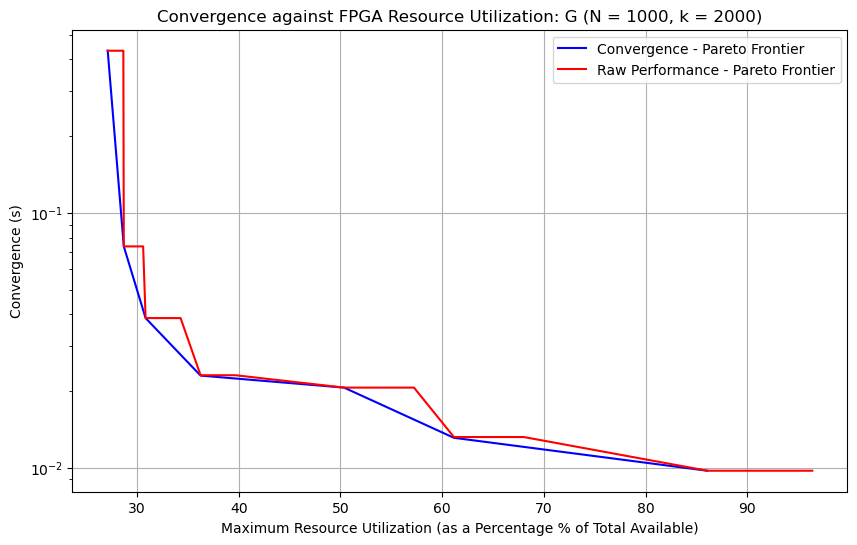

In [ ]:
# Plot
plt.figure(figsize=(10, 6))

# Plot the Pareto frontier line
plt.plot(pareto_resource_performance_new_frontier, convergence_values_pareto_new_frontier, color='blue', label='Convergence - Pareto Frontier')
plt.plot(resource_values_pareto_old_frontier, convergence_values_pareto_old_frontier, color='red', label='Raw Performance - Pareto Frontier')

plt.yscale('log')

# Add legend
plt.legend(fontsize=10, loc='upper right')  # Adjusted font size here

# Add labels and title
plt.xlabel('Maximum Resource Utilization (as a Percentage % of Total Available)', fontsize=10)  # Adjusted font size here
plt.ylabel('Convergence (s)', fontsize=10)  # Adjusted font size here
plt.title('Convergence against FPGA Resource Utilization: G (N = {}, k = {})'.format(graph['N'], graph['k']), fontsize=12)  # Adjusted font size here

# Show plot
plt.grid(True)

plt.savefig(f"images/n_1000_k_2000_analysis_pareto_plots.png") 
plt.show()